# Quantum pipeline using JAX backend

This performs an exact classical simulation.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 120
SEED = 0

In [3]:
import numpy as np

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 120
SEED = 0

### Read in the data and create diagrams

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [5]:

from lambeq import NewCCGParser
reader = NewCCGParser()

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

### Remove the cups

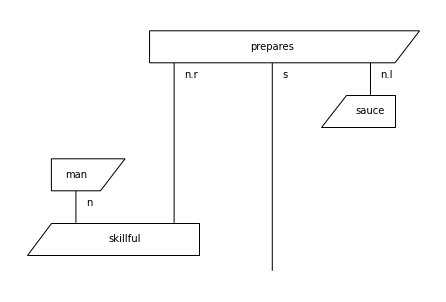

In [6]:
from discopy.rigid import Id

def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]

            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]


train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

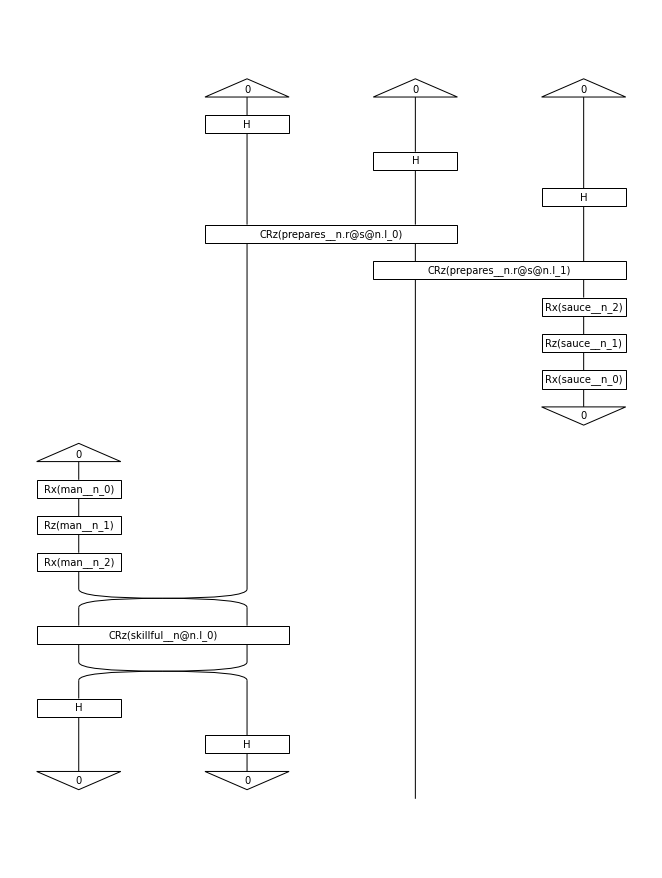

In [7]:
from lambeq.circuit import IQPAnsatz
from lambeq.core.types import AtomicType

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

### Parameterise

In [8]:
from discopy import Tensor
from jax import numpy as jnp

from lambeq.training import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

Tensor.np = jnp
model = NumpyModel.initialise_symbols(all_circuits)

### Define Evaluation Metric

In [9]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize Trainer

In [10]:
from lambeq.training import QuantumTrainer, SPSAOptimiser

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimiser,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'progress',
    seed=0
)

In [11]:
from lambeq.training import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [12]:
trainer.fit(train_dataset, val_dataset)

Epoch: 120, Batch: 3, loss: 0.1805: 100%|██████████| 360/360 [00:21<00:00, 16.90it/s] 


Training successful!


### Show results

Test accuracy: 0.9666666666666667


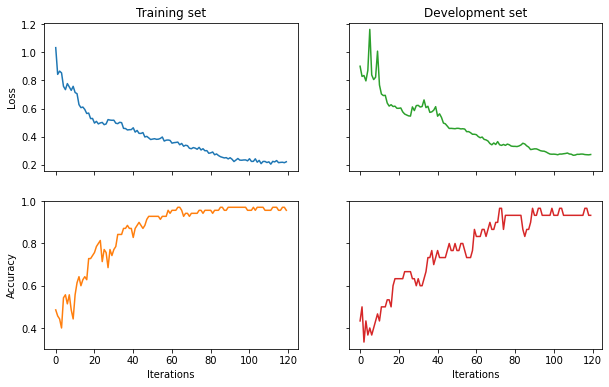

In [13]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)